In [1]:
# import public packages
import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
import scipy
import mne
import sys

from mne.time_frequency import tfr_morlet
from mne.baseline import rescale
from scipy.signal import spectrogram, hann, butter, filtfilt, hilbert
from scipy import signal, interpolate, stats
from scipy.interpolate import make_interp_spline, BSpline
from io import open
from importlib import reload

# import own functions
from utils import find_folders
import dat_preproc
import fix_annot_onsets
import mat2fif
import baseline_correction
import normalization
import power_spectrum

### Add Directories/ Load Files

In [2]:
reload(find_folders)
onedrive = find_folders.get_onedrive_path()
project_path = find_folders.get_onedrive_path("entrainment")
print(project_path)

C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT


In [ ]:
fname = 'Derivative_sub006_3MFU_ses-2020102101410392_run-BrainSense20201021014600.mat'

raw = mne.io.read_raw_fieldtrip(
    os.path.join(
        project_path,
        'data',
        'raw_data',
        'test',
        fname
    ),
    info = None
)

subID = 'Sub005'

In [ ]:
raw = mne.io.read_raw_fif(os.path.join(
    project_path,
        'data',
        'Fifs',
        'test',
        'Sub029_FIF.fif'
    )
)

subID = 'Sub029'

In [ ]:
reload(dat_preproc)
%matplotlib qt
matplotlib.rc('font', size=10)
x = raw.get_data(reject_by_annotation = 'omit',picks=[0,1])
raw = raw
win_samp = 250
noverlap = 0.5
window = hann(win_samp, sym=False)
f, t, Sxx = dat_preproc.fft_rawviz(raw, x, win_samp, noverlap)

In [ ]:
fft_name = str(subID)+'_FFT'
print(fft_name)

In [ ]:
#Saving the figures & files
fft_fig = os.path.join(project_path, 'figures','FFts','test/')
fft_file = os.path.join(project_path, 'data','FFTs','test/')

#plt.savefig(str(fft_fig)+str(fft_name),dpi = 300)

#np.save(str(fft_file)+str(fft_name)+'.npy',Sxx)

In [ ]:
#Saving the raw data as a fif file
raw2 = raw.copy()
Draw = raw2.get_data()
info = raw.info
new_raw = mne.io.RawArray(Draw, info)

#fif_name = os.path.join(project_path, 'data','Fifs','test/',str(subID)+'_FIF.fif')
#new_raw.save(fif_name)


In [ ]:
#Zscore Normalization of raw data & plot of new figure
reload(baseline_correction)
data = Sxx
t = t
baseline = (None, None)
raw = raw
stim_ch = 0
bs_data = baseline_correction.baseline_corr(data, t, baseline, raw = raw, stim_ch = 5)

In [ ]:
fft_fig = os.path.join(project_path, 'figures','FFts','test/')
fft_file = os.path.join(project_path, 'data','FFTs','test/')

plt.savefig(str(fft_fig)+str(fft_name)+'_zscored',dpi = 300)
np.save(str(fft_file)+str(fft_name)+'_zscored'+'.npy',bs_data)

In [ ]:
d = {'onset': [1, 140, 303],
    'duration': [10, 17, 10],
    'description': ['StimOff','StimOn','Rebound']
}

epoch_df = pd.DataFrame(data = d)
print(epoch_df)

In [ ]:
## Print Power Spectra with Raw Data
reload(dat_preproc)
filt_dat = raw.get_data()
time_onsets = epoch_df
window = 250
noverlap = 0.5
ylim2 = 0.4

fig = plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
title1 = str(subID)+ '_LSTN'
ps1 = dat_preproc.epoch_ps(filt_dat, time_onsets, window, noverlap, 0, 0.3, title1)

plt.subplot(1,2,2)
title2 = str(subID)+ '_RSTN'
ps2 = dat_preproc.epoch_ps(filt_dat, time_onsets, window, noverlap, 1, 0.3, title2)

plt.show()

In [ ]:
## Printing the Power Spectra (RAW)
ps_all = np.concatenate((ps1,ps2), axis = 0)
ps_df = pd.DataFrame(np.transpose(ps_all),
    columns = ['StimOff_LSTN','StimOn_LSTN','Rebound_LSTN',
    'StimOff_RSTN','StimOn_RSTN','Rebound_RSTN'],
    )
print(ps_df)

In [ ]:
#Saving the figures & files
fft_fig = os.path.join(project_path, 'figures','Power_Spectra','test/')
fft_file = os.path.join(project_path, 'data','power_spectra','test/')

plt.savefig(str(fft_fig)+str(fft_name)+'_PS',dpi = 150)
ps_df.to_csv(str(fft_file)+str(fft_name)+'_PS.csv')

In [ ]:
## Print Power Spectra with Zscored Data
fig, axes = plt.subplots(1,1, figsize = (8,6))

side = 0

ps_m1s0 = np.mean(bs_data[side,:,epoch_df.onset[0]:epoch_df.onset[0]+ epoch_df.duration[0]],1)
ps_m1s1 = np.mean(bs_data[side,:,epoch_df.onset[1]:epoch_df.onset[1]+ epoch_df.duration[1]],1)
ps_reb = np.mean(bs_data[side,:,epoch_df.onset[2]:epoch_df.onset[2]+ epoch_df.duration[2]],1)

plt.plot(np.arange(1,127),ps_m1s0,label = epoch_df.description[0])
plt.plot(np.arange(1,127),ps_m1s1,label = epoch_df.description[1])
plt.plot(np.arange(1,127),ps_reb,label = epoch_df.description[2])
    
plt.xlim(60,90)
plt.xlabel('Frequency [Hz]')
plt.ylabel('LFP Power (z-scored)')
    
plt.legend()
plt.show()


In [ ]:
ps_allzscored_df = pd.DataFrame(
    {
        'Spontan': ps_m1s0,
        'StimOn': ps_m1s1,
        'Rebound': ps_reb
    }
)
print(ps_allzscored_df)

In [ ]:
plt.savefig(str(fft_fig)+str(fft_name)+'_Contra_zscoredPS',dpi = 150)
ps_allzscored_df.to_csv(str(fft_file)+str(fft_name)+'_Contra_zscoredPS.csv')

### Checking Spectral Width

In [ ]:
#Import the power spectrum csv
ps_tbl = pd.read_csv(os.path.join(
    project_path,
        'data',
        'power_spectra',
        'test',
        'Sub029_FFT_PS.csv'
))

subID = 'Sub029'

x1 = ps_tbl.StimOff_RSTN[50:101]
x2 = ps_tbl.StimOn_RSTN[50:101]
plt.plot(np.arange(0,51),x1)
plt.plot(np.arange(0,51),x2)
plt.xticks(np.arange(0,51,10), labels = np.arange(50,101,10))

plt.ylim(0,0.2)

In [ ]:
reload(power_spectrum)
%matplotlib qt

height = 0.04

peaks1, results_half1, peaks2, results_half2 = power_spectrum.powerSpectrum_width(x1, x2, height, subID)
print(results_half1)
print(results_half2)

In [ ]:
plt.savefig(os.path.join(
    project_path,
    'figures',
    'Power_Spectra',
    'test',
    str(subID)+'_PSWidth'
),
dpi = 150)

### Average all Power Spectra and Plot them

In [3]:
## Interpolate and plot power spectrum
trial_ps = pd.read_csv(os.path.join(
    project_path,
        'data',
        'power_spectra',
        'test',
        'Sub005_FFT_PS.csv'
)
)

print(trial_ps)

     Unnamed: 0  StimOff_LSTN  StimOn_LSTN  Rebound_LSTN  StimOff_RSTN  \
0             0      0.377289     0.553629      0.858927      0.203042   
1             1      1.911971     2.712471      3.930662      0.810503   
2             2      2.513051     2.390778      3.551067      1.067583   
3             3      1.677302     2.069654      2.196010      0.609942   
4             4      1.402737     0.998402      2.721627      0.239860   
..          ...           ...          ...           ...           ...   
121         121      0.004851     0.005653      0.003814      0.000703   
122         122      0.000209     0.000237      0.000202      0.000120   
123         123      0.000210     0.000171      0.000211      0.000158   
124         124      0.000180     0.000149      0.000196      0.000196   
125         125      0.000082     0.000058      0.000095      0.000085   

     StimOn_RSTN  Rebound_RSTN  
0       0.107721      0.221126  
1       0.676132      1.333687  
2       0.77

(50.0, 100.0)

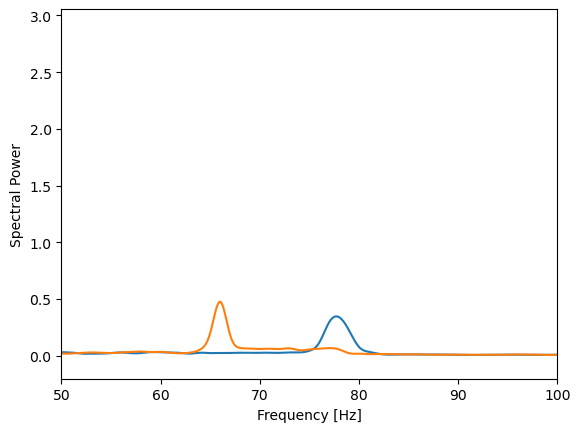

In [9]:
reload(dat_preproc)
dat_preproc.mypower(trial_ps['StimOff_RSTN'])
dat_preproc.mypower(trial_ps['StimOn_RSTN'])
plt.xlim(50,100)

In [ ]:
os.path.join(
   project_path,
   'data', 'power_spectra', 'test'
)

In [14]:
#loop through all csv files
from scipy import stats
all_spontan = []
all_subh = []

ps_path = os.path.join(
   project_path,
   'data', 'power_spectra', 'test'
)

for filename in os.listdir(ps_path):
   if filename.endswith('FFT_Ipsi_zscoredPS.csv'):
   #with open(os.path.join(ps_path, filename), 'r') as f: # open in readonly mode
      this_df = pd.read_csv(os.path.join(ps_path,filename))
      this_spontan = this_df['Spontan']
      this_subh = this_df['StimOn']


   all_spontan.append(this_spontan)
   all_subh.append(this_subh)


NameError: name 'this_spontan' is not defined

In [15]:
print(filename)

Sub005_FFT_Contra_zscoredPS.csv


In [ ]:
all_spontan_df = pd.DataFrame(np.transpose(all_spontan))
all_subh_df = pd.DataFrame(np.transpose(all_subh))

In [ ]:
%matplotlib qt
plt.plot(all_spontan_df,color = 'red',lw = 0.5, alpha = 0.3, label = 'Med On-Stim Off')
plt.plot(all_subh_df,color = 'blue',lw = 0.5, alpha = 0.3, label = 'Med On-Stim On')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlim(50,90)
plt.ylim(-1,1)
plt.xlabel('Frequency [Hz]')
plt.ylabel('LFP Power [z-scored]')

In [ ]:
plt.savefig(os.path.join(
    project_path,
    'figures',
    'Power_Spectra',
    'test',
    'AllSub_ZscoredIPSI'
),
dpi = 200)

In [ ]:
all_psSpontan = pd.read_csv(os.path.join(
    project_path,
        'results',
        'AllSpontan_PsZscored.csv'
))


all_psSubharm = pd.read_csv(os.path.join(
    project_path,
        'results',
        'AllSubharm_PsZscored.csv'
))

In [ ]:
all_psSpontan = all_psSpontan.drop('Sub029', axis=1)

In [ ]:
all_ps_mean1 = np.mean(all_psSpontan,1)
all_ps_sem1 = stats.sem(all_psSpontan,1)

all_ps_mean2 = np.mean(all_psSubharm,1)
all_ps_sem2 = stats.sem(all_psSubharm,1)

In [ ]:
plt.plot(np.arange(1,127), all_ps_mean1, label = 'Spontaneous FTG')
plt.fill_between(np.arange(1,127), all_ps_mean1-all_ps_sem1, all_ps_mean1+all_ps_sem1, alpha = 0.2)

plt.plot(np.arange(1,127), all_ps_mean2, label = 'DBS-Induced FTG')
plt.fill_between(np.arange(1,127), all_ps_mean2-all_ps_sem2, all_ps_mean2+all_ps_sem2, alpha = 0.2)

plt.xlim(50, 100)
plt.ylim(-0.4, 2)
plt.legend()

plt.xlabel('Frequency [Hz]')
plt.ylabel('LFP Power [z-scored]')
plt.title('Averaged Power Spectra [N = 6]')

In [ ]:
plt.savefig(os.path.join(
    project_path,
    'results',
    'Avg_PS'
),
dpi = 200)

In [ ]:
###Compare Power Spectra Widths

widths_tbl = pd.read_csv(os.path.join(
    project_path,
    'results',
    'PS_Widths.csv'
))
print(widths_tbl)

In [ ]:
import mlxtend

In [ ]:
p_value = mlxtend.permutation_test(
    widths_tbl['WidthMed'], widths_tbl['WidthSubh'], paired=True, method="approximate", seed=0, num_rounds=100000
)

print(p_value)

In [ ]:
np.arange(0,2)

In [ ]:
dat_to_box = widths_tbl.iloc[:,[3,4]]
plt.boxplot(dat_to_box)
